# Langtjern data processing for the PROGNOS project

## Required python libraries and files, setup variables

In [1]:
import sys
import LangtjernWeather as lw
import numpy as np
import datetime
import pandas as pd
import getpass
import matplotlib
import matplotlib.pyplot as plt
import getpass
import itertools as IT
from itertools import compress
from matplotlib import rc
import shutil
import os
import re
import pickle
import pylab
import statsmodels.api as sm

#Setting matplotlib style
matplotlib.style.use('ggplot')
%matplotlib inline
pd.options.mode.chained_assignment = None
rc('text', usetex=True)
rc('xtick', labelsize = 16)
rc('ytick', labelsize = 16)
rc('font', size = 16)
#login function
def login():
    username = input("Username: [JLG] ") #default username JLG
    if not username :
        username = "JLG"
    password = getpass.getpass('Password: ')
    return username, password

#Creating directories to store files. This will overwrite if the directory already exists
def create_dir(dir_name) :
    if not os.path.exists(dir_name) :
        os.makedirs(dir_name)
    else :
        shutil.rmtree(dir_name)
        os.makedirs(dir_name)
#Helper function for plotting
def plot_df(df) :
    num_cols = len(df.columns)
    fig, axes = plt.subplots(nrows = num_cols, ncols = 1, figsize = (20, num_cols * 5))
    for name,ax_h in zip(df.columns, axes) :
        plt.sca(ax_h)
        plt.plot(df.index,df[name])
        #df[name].plot(ax = ax_h)
        ax_h.set_ylabel(name)
    return fig
    

#Sanity check
print("Using python version:")
print(sys.version)
print("Paths to python libraries:")
print(sys.path)

#Creating directory to save results
result_dir = './results/'
create_dir(result_dir)    

Using python version:
3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
Paths to python libraries:
['', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python36.zip', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/lib-dynload', '/usr/lib/python3.6', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/site-packages', '/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/site-packages/IPython/extensions', '/home/jose-luis/.ipython']


## Asking for credentials to AquaMonitor.

In [2]:
username,password = login()

#Folder where the downloaded data will be saved
root = "./DownloadedData/"
create_dir(root)

Username: [JLG] 
Password: ········


## Defining period to download

In [3]:
## Defining period to download

#Setting up date to load data

#fromDate = "2015/08/20"  #Please don't change the format
#toDate = "2015/09/15"

#fromDate = "2014/09/01"
#toDate = "2014/12/31"

fromDate = "2010/01/02"
toDate = "2018/10/01"



## Loading Langtjern data

For details, please se the "AquaMonitor.py" and "LangtjernWeather.py" that interact with AquaMonitor.

**Please note**: The time in AquaMonitor is given in UTC and should be changed to Norwegian Standard time

In [4]:
allData = lw.getLangtjernData(username,password,root,fromDate,toDate)
del password
print("The data that were read are: ")
for dummy,i in allData.items() :
    #i.index = i.index + pd.DateOffset(hours=1)
    print (i.columns)

The data that were read are: 
Index(['Globalstråling_W/m2', 'Lufttemperatur_°C ', 'Nedbør_mm',
       'Relativ luftfuktighet_%', 'Vindhastighet_m/s',
       'Vindhastighet (maks)_m/s', 'Vindretning_°'],
      dtype='object')
Index(['Depth1', 'Depth2', 'O2 (metning)_%', 'Temperatur_C'], dtype='object')
Index(['Depth1', 'Depth2', 'CDOM_µg/L', 'CO2_ppm', 'Konduktivitet_mS/m', 'pH',
       'Temperatur_C', 'Vannstand_m'],
      dtype='object')
Index(['Depth1', 'Depth2', 'CDOM_µg/L', 'Temperatur_C', 'Vannstand_m'], dtype='object')
Index(['Depth1', 'Depth2', 'Al/IL_µg/l', 'Al/L_µg/l', 'Al/R_µg/l',
       'ANC_µEkv/L', 'Ca_mg/L', 'Cl_mg/L', 'DOC_mg/l', 'Hg_ng/l', 'K_mg/L',
       'Konduktivitet_mS/m', 'Mg_mg/L', 'Na_mg/L', 'pH', 'SiO2_mg/l',
       'SO4_mg/L', 'TOC_mg/l', 'TOTN_µg/l', 'TOTP_µg/l', 'UV absorbans_Abs/cm',
       'UV-Abs. 254nm_Abs/cm', 'UV-Abs. 365nm_Abs/cm', 'UV-Abs. 410nm_Abs/cm'],
      dtype='object')


## Getting missing atmospheric pressure data from nearest station

Since atmospheric pressure is not measured at Langtjern, data from the nearest Meteorologisk Institutt (metno) stations measuring it will be used. This also applies to cloud cover.

The metno data is downloaded using the following notebooks:

* [Catchment delineation](https://nbviewer.jupyter.org/github/Lecheps/Catchment_delineation/blob/master/Catchment_delineation.ipynb)
* [Data download from metno](https://nbviewer.jupyter.org/github/Lecheps/Catchment_delineation/blob/master/metno_download.ipynb)

The atmospheric pressure is formatted as a pandas dataframe, saved as a pickle and loaded here:

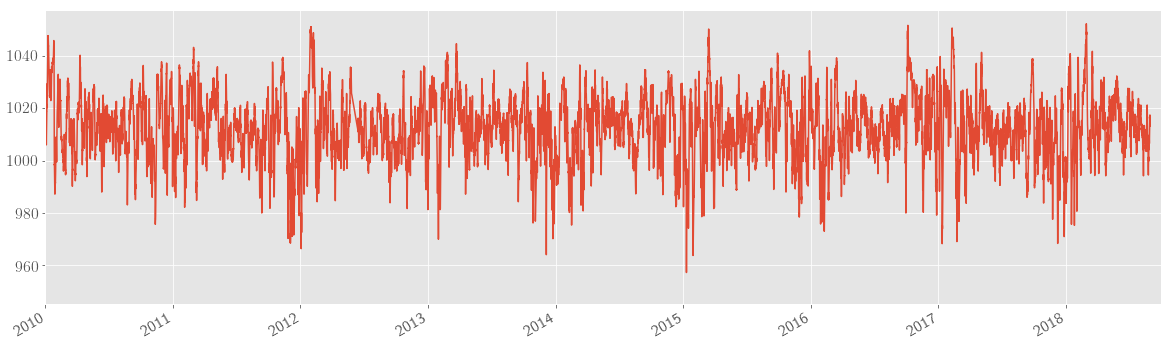

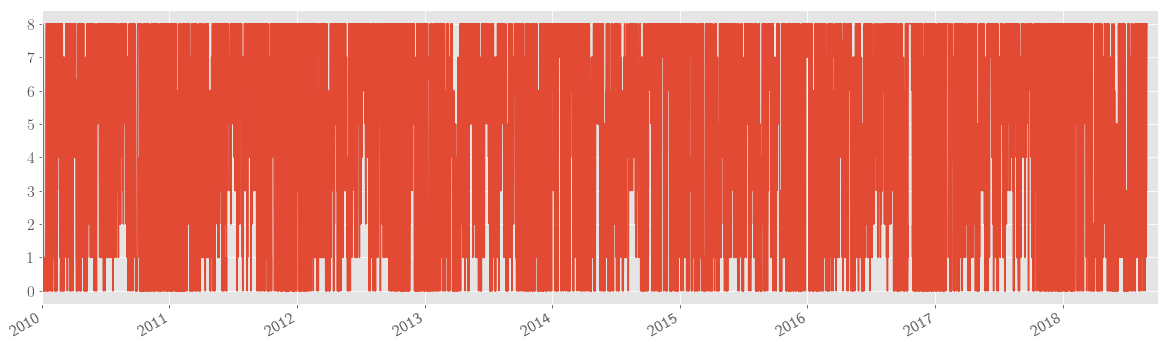

In [4]:
with open('/home/jose-luis/Envs/catchment/Catchment_delineation/data.pickle', 'rb') as handle:
    metnoData = pickle.load(handle)
pylab.rcParams['figure.figsize'] = (15, 4)    

mslp = metnoData.filter(regex=".*air.pressure.*")
cc = metnoData.filter(regex=".*cloud.*")
cc.replace(-3,0,inplace=True)

cc = cc.mean(axis=1)
cc.interpolate(inplace=True)
mslp = mslp.mean(axis=1)
mslp.interpolate(inplace=True)

plt.figure(figsize=(20,6))
mslp.plot(xlim= (pd.Timestamp(fromDate), pd.Timestamp(toDate)))
plt.figure(figsize=(20,6))
cc.plot(xlim = (pd.Timestamp(fromDate), pd.Timestamp(toDate)))


cc=cc.to_frame()
cc.index.name='date'
cc = cc.rename(columns= {0: 'cc'})
mslp=mslp.to_frame()
mslp.index.name='date'
mslp = mslp.rename(columns= {0: 'mslp'})

In [5]:
display(metnoData)

,"(air_pressure_at_sea_level _ SN24880,)","(air_pressure_at_sea_level _ SN24890,)","(cloud_area_fraction _ SN24880,)","(cloud_area_fraction _ SN24890,)"
date,,,,
2000-01-01 00:00:00,NaN,NaN,NaN,NaN
2000-01-01 06:00:00,1010.1,NaN,8.0,NaN
2000-01-01 12:00:00,1012.9,NaN,2.0,NaN
2000-01-01 15:00:00,1014.3,NaN,1.0,NaN
2000-01-01 18:00:00,1015.6,NaN,0.0,NaN
2000-01-02 00:00:00,NaN,NaN,NaN,NaN
2000-01-02 06:00:00,1007.4,NaN,8.0,NaN
2000-01-02 12:00:00,1004.1,NaN,5.0,NaN
2000-01-02 15:00:00,1005.2,NaN,5.0,NaN


## Saving meteo data

* u10: east-west wind speed m/s
* v10: north south wind speed m/s
* mslp: mean sea level pressure bar ->using data from nearby station
* t2: temperature degree Celsius
* hum: Relative humidity %
* cc: cloud cover -> using data from nearby station

The results will be saved in *Langtjern\_weather.dat*

The type of GOTM_weater is <class 'pandas.core.frame.DataFrame'>


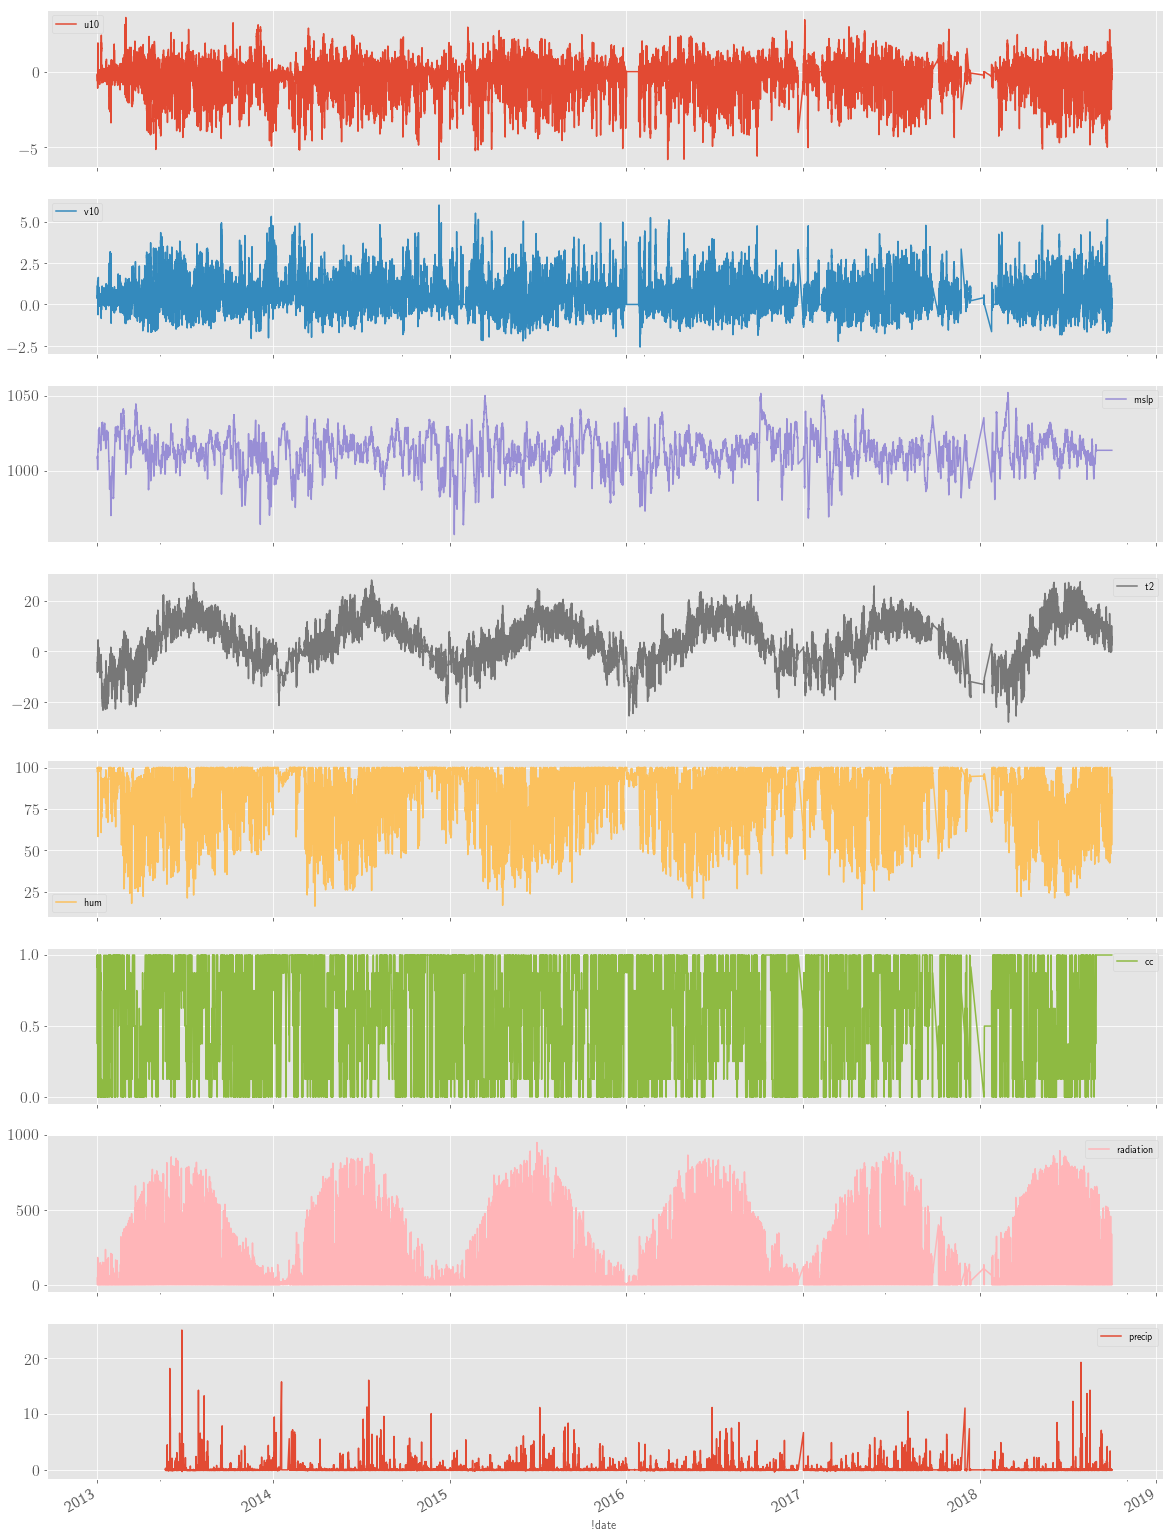

In [6]:
#Saving the meteo data
GOTM_weather = allData['weather'].iloc[:,[4,4,6,1,3,0,0,2]]
GOTM_weather.index.name = '!date'
bla = 1013.0
blabla = 0.6
GOTM_weather.columns = ['u10', 'v10', 'mslp', 't2', 'hum', 'cc','radiation','precip'] #Temporarily storing wind direction in mslp
GOTM_weather.loc[:,'u10'] = GOTM_weather.loc[:,'u10'] * np.cos(np.deg2rad(GOTM_weather.loc[:,'mslp']))
GOTM_weather.loc[:,'v10'] = GOTM_weather.loc[:,'v10'] * np.sin(np.deg2rad(GOTM_weather.loc[:,'mslp']))
GOTM_weather.loc[:,'mslp'] = np.nan
GOTM_weather.loc[:,'cc'] = np.nan
GOTM_weather.update(cc)
GOTM_weather['cc'] /= 8.0 
GOTM_weather.update(mslp)
GOTM_weather.interpolate(inplace=True) #Linear interpolation of missing values and NaN's

#Plotting variables
GOTM_weather.plot(subplots=True, layout=(len(GOTM_weather.columns),1),figsize=(20,30))

#Setting up GOTM formatting for saving as a .dat file
GOTM_weather.loc[:,'mslp'] = GOTM_weather['mslp'].map(lambda x : '%0.2f' % x)
GOTM_weather.loc[:,'hum'] = GOTM_weather['hum'].map(lambda x : '%0.2f' % x)
GOTM_weather.loc[:,'cc'] = GOTM_weather['cc'].map(lambda x : '%0.3f' % x)

print("The type of GOTM_weater is %s" % type(GOTM_weather))
#Saving    
GOTM_weather.loc[:,GOTM_weather.columns != 'radiation'].to_csv(result_dir + 'langtjern-weather.dat',\
                    sep = "\t",float_format='%0.2f',\
                    date_format = '%Y-%m-%d %H:%M:%S')

#temperature = GOTM_weather['t2'].resample('d').mean()
#temperature.to_csv("temperature_langtjern.csv")
#precip = GOTM_weather['precip'].resample('d').sum()
#precip.to_csv('precip_langtjern.csv')



GOTM_weather['radiation'].to_csv(result_dir + 'langtjern-radiation.dat',\
                    sep = "\t",float_format='%0.3f',\
                    date_format = '%Y-%m-%d %H:%M:%S')

In [7]:
GOTM_weather[['t2','precip']].to_pickle('langtjern.pickle')

## Saving inlet data

Discharge is obtained from stage with the use of the following rating curve:

 $ \textrm{if } gh > 0.345 \textrm{ then }  q = 2.391 \times (gh - 0.345)^{2.5} \textrm{ else } q = 0.0001 $
 
 $q(m^3/s) \textrm { and } gh(m) $
 
**Please note** In the info received from NVE the value for the multiplier was 2391, which unlikely large discharge. This was changed to 2.391
 
**Please note** The inlet just covers a portion of the catchment and will be scaled by area in order to be representative of the entire catchment. This is a kludge.

CDOM data prior to 2012 are highly uncertain. It is recommended not to use them.
 
 Two data files will be saved:
 
 * CDOM data in $\mu g/l$
 * Discharge and water temperature in $m^3/s$ and $^\circ C$ respectively 
 

The average discharge is: 
0.1077224500872315


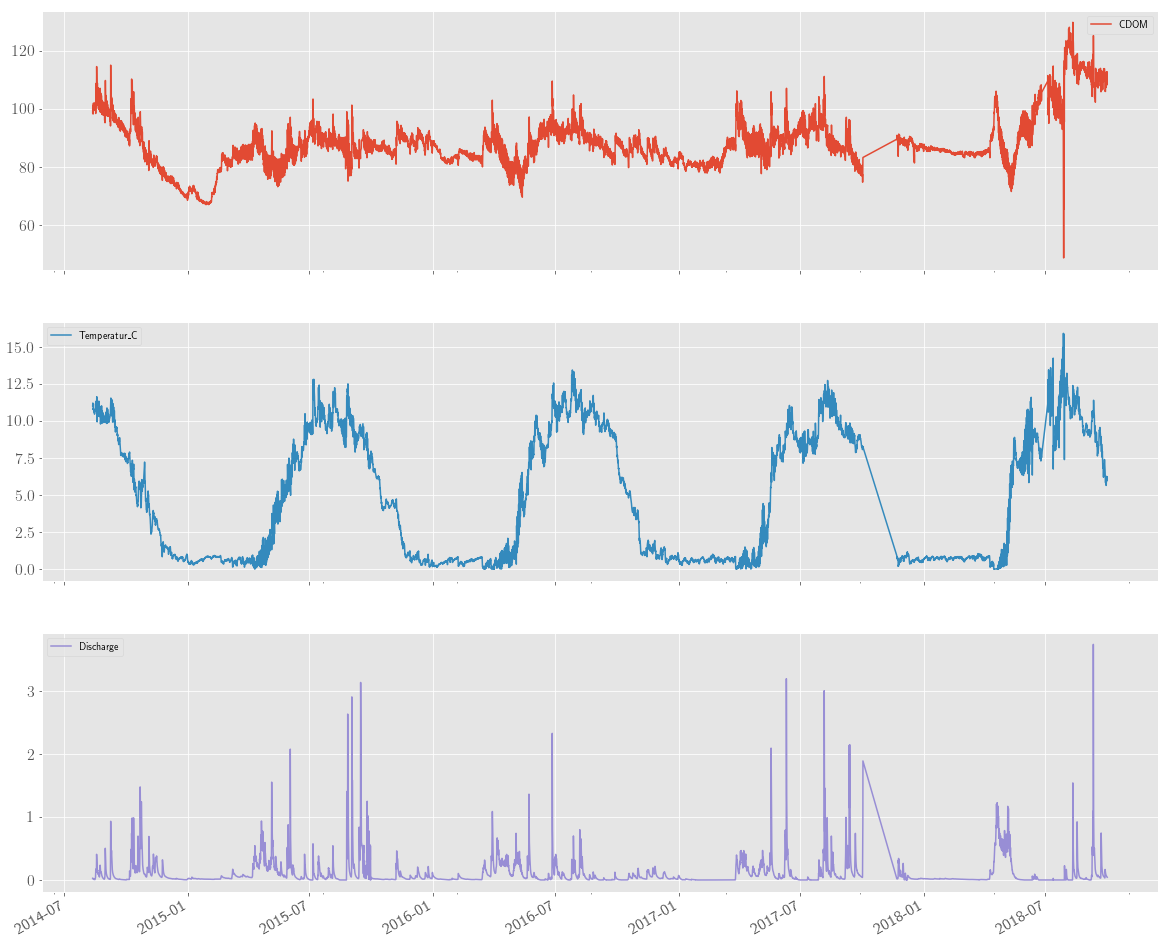

In [8]:
#Filling in missing values and nans from inlet data using linear interpolation
inlet = allData['inlet']
inlet.interpolate(inplace=True)


#Transforming stage into discharge
inletQ = lambda x : 2.391* np.power(x - 0.345, 2.5) if (x > 0.345) else 0.0001
o2FromT = lambda x : x * 2
inlet =  inlet.rename(columns={'Vannstand_m':'Discharge',u'CDOM_µg/L' : 'CDOM'})
inlet['Discharge'] = inlet['Discharge'].apply(inletQ)
inlet['Discharge'] = inlet['Discharge'] * (4.8 + 0.23) / 0.8
inlet['Temperatur_C'] = inlet['Temperatur_C'].apply(lambda x : 0.0 if x < 0.0 else x)


#allData['inlet']['O2'] = allData['inlet']['Temperatur_C'].map(o2FromT)
#df['Col3'] = df['Col2'].map(lambda x: 42 if x > 1 else 55)
#allData['inlet'].loc[:,'O2'] = allData['inlet'].loc[:,'O2'].apply(o2FromT)

print("The average discharge is: ")
print (np.mean(inlet.loc[:,'Discharge']))

#Visualizing data
inlet = inlet.rename(columns=lambda x : re.sub('_','\\_',x))
inlet.drop(['Depth1', 'Depth2'], axis=1,inplace=True)
inlet.plot(subplots=True, layout=(len(inlet.columns),1),figsize=(20,18))   

#Saving inlet data
fcdom = open(result_dir + 'langtjern-inlet-cdom-ug-per-l.dat','w')
fdisch = open(result_dir + 'langtjern-inlet-q.dat','w')
#Splitting cdom into doma and domb
fdoma =  open(result_dir + 'langtjern-inlet-doma-ug-per-l.dat','w')
fdomb =  open(result_dir + 'langtjern-inlet-domb-ug-per-l.dat','w')


for i,j in inlet.iterrows() :
    fcdom.write(datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' ' + str(j.loc['CDOM']) + '\n')
    fdoma.write(datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' ' + str(j.loc['CDOM']*0.1) + '\n')
    fdomb.write(datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' ' + str(j.loc['CDOM']) + '\n')
    fdisch.write(datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' ' \
                 + str(j['Discharge']) + ' ' + str(j['Temperatur\\_C']) + '\n') 

fcdom.close()
fdisch.close()

# fig.suptitle('Measured inlet data', size = 'xx-large')
# fig.tight_layout()

## Saving outlet data

Discharge is obtained from the stage using the following rating curve:

 $ \textrm{if } gh > 0.37 \textrm{ then }  q = 3.2136 \times gh^{2.453} \textrm{ else } q = 3.794 \times gh^{2.692}$
 
$q(m^3/s) \textrm { and } gh(m) $

**Please note** The gauge height is not directly measured at the flume but at some upstream point and the gauge height should be corrected by a height (substraction) of *0.1403*

CDOM at the outlet must be corrected because of recalibration in 2012 $10\mu g/l$ should be added to all values before _22/11/2012_ NO time.

Additionaly with respect to the inlet, the conductivity is measured here as well.

Three data files will be saved:
* CDOM data in  μg/l 
* Discharge and water temperature in  m3/s  and  ∘C respectively
* Conductivity in mS/m

In [9]:
print(inlet.columns)

Index(['CDOM', 'Temperatur\_C', 'Discharge'], dtype='object')


Depth1                   0.000000
Depth2                   0.000000
CDOM                   120.100000
CO2_ppm               3057.580000
Konduktivitet_mS/m       9.940000
pH                       6.437000
Temperatur_C            26.620000
Discharge                1.358587
dtype: float64
The average discharge is: 
0.1056605902450427
Index(['CDOM', 'CO2\_ppm', 'Konduktivitet\_mS/m', 'pH', 'Temperatur\_C',
       'Discharge'],
      dtype='object')


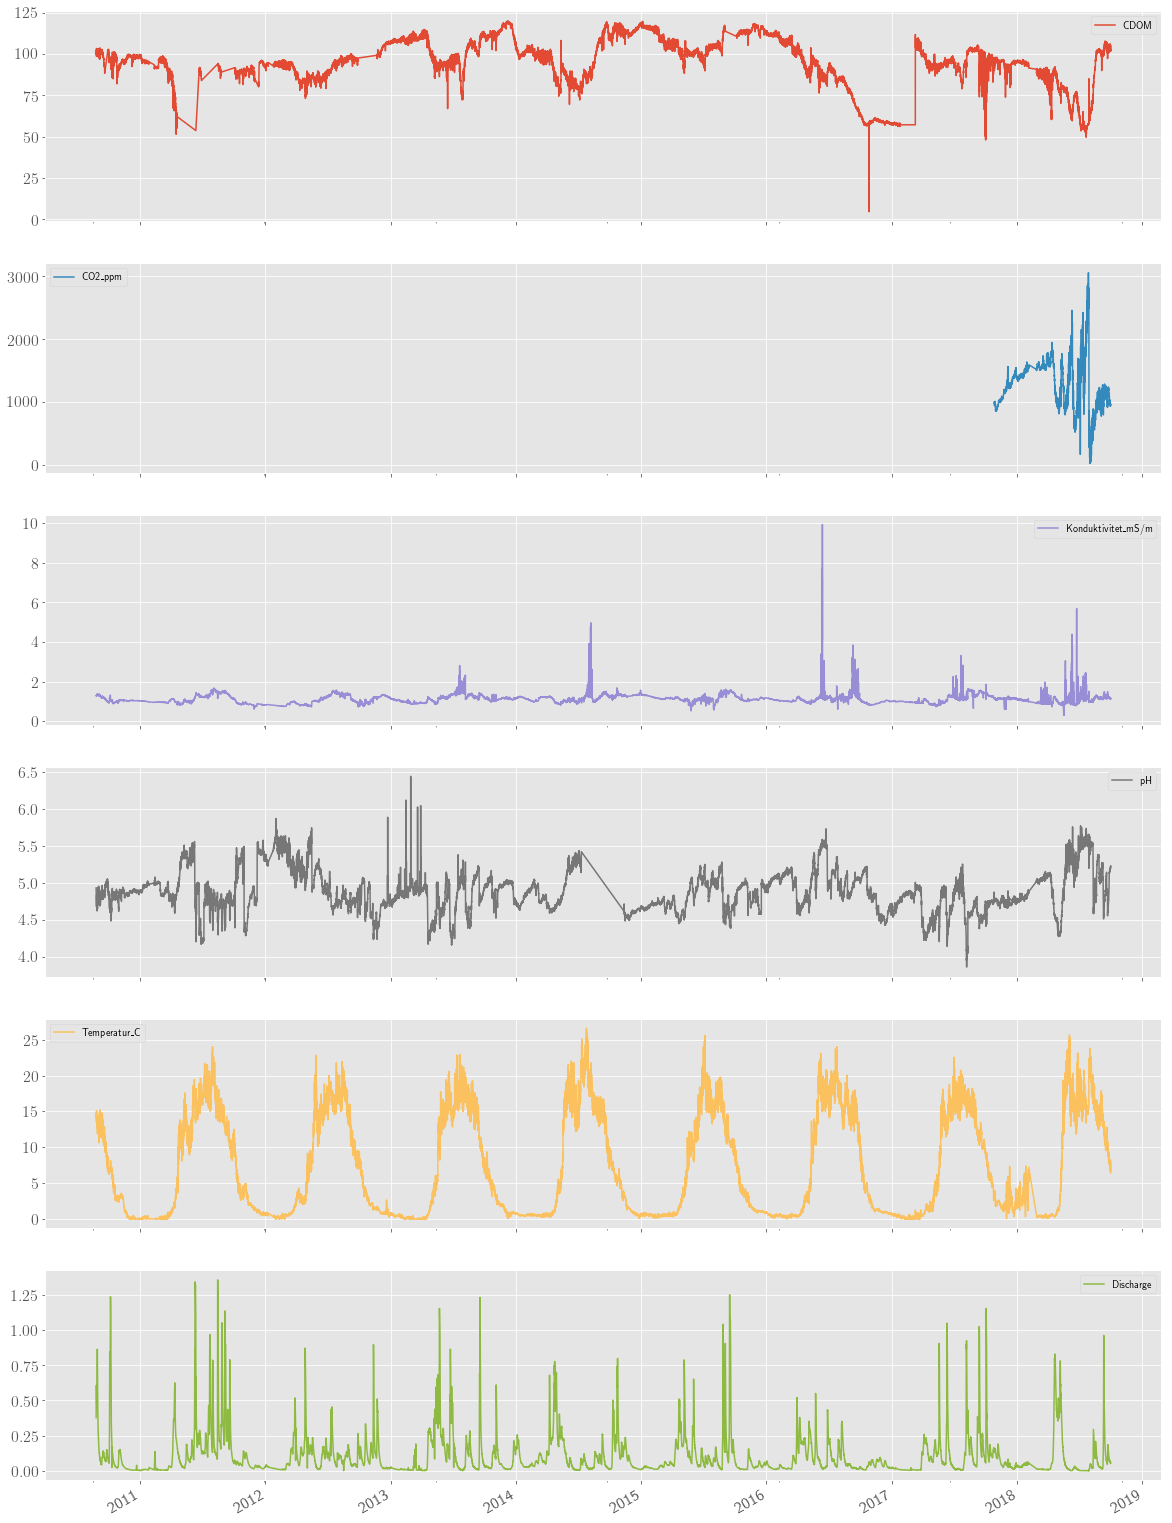

In [10]:
#Filling in missing values and nans from inlet data using linear interpolation
outlet = allData['outlet']
outlet.interpolate(inplace=True) 

#Transforming stage into discharge
#outlet:If(([Stage]-0.315)<=0.37,3.2136*([Stage]-0.315)^2.453,
#3.794*(([Stage]-0.315)-0.01)^2.692) (0.315 is the offset)

outletQ = lambda x : 3.2136 * np.power(x - 0.315,2.453) if x > 0.37 else 3.794 * np.power(x - 0.315, 2.692)  

outlet = outlet.rename(columns={'Vannstand_m':'Discharge',u'CDOM_µg/L' : 'CDOM'})
outlet['Discharge'] = outlet['Discharge'].apply(outletQ)
outlet['Discharge'] = outlet['Discharge'] * 1.0
outlet['Temperatur_C'] = outlet['Temperatur_C'].apply(lambda x : 0.0 if x < 0.0 else x)

print(outlet.max())

print("The average discharge is: ")
print (np.mean(outlet['Discharge']))

#Visualizing data
outlet = outlet.rename(columns=lambda x : re.sub('_','\\_',x))
outlet.drop(['Depth1', 'Depth2'], axis=1,inplace=True)
outlet.plot(subplots=True, layout=(len(outlet.columns),1),figsize=(20,30))  

print(outlet.columns)
#fig = plot_df(outlet.iloc[:,2:])

#Saving outlet data
fcdom =  open(result_dir + 'langtjern-outlet-cdom-ug-per-l.dat','w')
fdisch = open(result_dir + 'langtjern-outlet-q.dat','w')
fcond =  open(result_dir + 'langtjern-outlet-cond-us-per-m.dat','w')
fcdom_obs = open(result_dir + 'langtjern_cdom_out.obs', 'w')


#fpH = open('langtjern-outlet_ph.dat','w')

for i,j in outlet.iterrows() :
    fcdom.write (datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' ' + str(j.loc[u'CDOM']) + '\n')
    fcdom_obs.write (datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' -0.0 ' + str(j.loc[u'CDOM']) + '\n')
    fdisch.write(datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' -' \
                 + str(j['Discharge']) + ' ' + str(j['Temperatur\\_C']) + '\n')
    fcond.write (datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' ' \
                 + str(j.loc['Konduktivitet\\_mS/m']) + '\n')
    
   # fpH.write(datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' ' + str(j.loc['pH']) + '\n')
fcdom.close()
fdisch.close()


In [11]:
print(outlet.max())

CDOM                    120.100000
CO2\_ppm               3057.580000
Konduktivitet\_mS/m       9.940000
pH                        6.437000
Temperatur\_C            26.620000
Discharge                 1.358587
dtype: float64


## Saving profile data

GOTM will fill in the missing values in the profile data. Therefore only the depths at which there actually are measurements are included here.

Two profiles will be saved:

* One for temperature in $^{\circ}C$
* One for $O_2$ in _%_

In [12]:
#Storing profile data in an array for visualization
t = []
O2 = []
O2_y = []

#Getting indexes to unique dates (each date a profile)
idx_list = {}
idx_list[allData['lake'].index[0]] = [0]
cnt = 0
for i in allData['lake'].index[1:]:
    if i == allData['lake'].index[cnt]:
        idx_list[i].append(cnt+1)
    else :
        idx_list[i] = [cnt+1]   
    cnt = cnt + 1

#Finding unique depths
unik_depth_O2 = sorted(list(allData['lake'].loc[:,'Depth1'].unique()))
unik_depth_t = sorted(list(allData['lake'].loc[:,'Depth2'].unique()))
ind_O2_dict = dict((k,i) for i,k in enumerate(unik_depth_O2))
ind_t_dict = dict((k,i) for i,k in enumerate(unik_depth_t))

isvalid_O2_and_t = np.logical_not(np.isnan(allData['lake'].iloc[:,2:4]).values)
  
#Preallocating arrays to store O2 and temperature data
O2 = np.zeros((len(idx_list),len(unik_depth_O2)))
O2[:] = np.NaN
t = np.zeros((len(idx_list),len(unik_depth_t)))
t[:] = np.NaN
#date_x = np.zeros(len(idx_list),dtype='datetime64[s]')
date_x = list(allData['lake'].index.unique())

#Filling up O2 and t arrays
cnt = 0;
for key,val in sorted(idx_list.items()):
    is_data_O2 = isvalid_O2_and_t[val,0]
    is_data_t = isvalid_O2_and_t[val,1]
    date_x[cnt] = (allData['lake'].index[val[0]])
    val_O2 = allData['lake'].iloc[list(compress(val,is_data_O2)),[0,2]]
    val_t =  allData['lake'].iloc[list(compress(val,is_data_t)),[1,3]]
    dict_O2 = dict(zip(val_O2.iloc[:,0],val_O2.iloc[:,1])) 
    dict_t = dict(zip(val_t.iloc[:,0],val_t.iloc[:,1]))
    for key_,val_ in dict_O2.items() :
        O2[cnt,ind_O2_dict[key_]] = val_
    for key_,val_ in dict_t.items() :
        t[cnt,ind_t_dict[key_]] = val_  
    cnt += 1

O2 = np.transpose(O2)
t = np.transpose(t)
t[t < 0.0] = 0.0

#O2 = O2/100;
#Transforming temperature saturation percentage to concentration in mmol/m3
O2 = O2/100 * 1e3 * (14.59 - 0.3955*t + 0.0072*t*t - 0.0000619*t*t*t) / (31.9988)

print(O2)
    
print('Done!' )

[[         nan          nan          nan ...          nan          nan
           nan]
 [298.39912496 299.97480295 299.80186164 ... 278.54525306 278.55777403
  278.47877579]
 [         nan          nan          nan ...          nan          nan
           nan]
 ...
 [         nan          nan          nan ...          nan          nan
           nan]
 [         nan          nan          nan ... 295.64815896 296.56873113
  297.58585607]
 [185.24277658 185.88893808 191.17560469 ...          nan          nan
           nan]]
Done!


/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in less


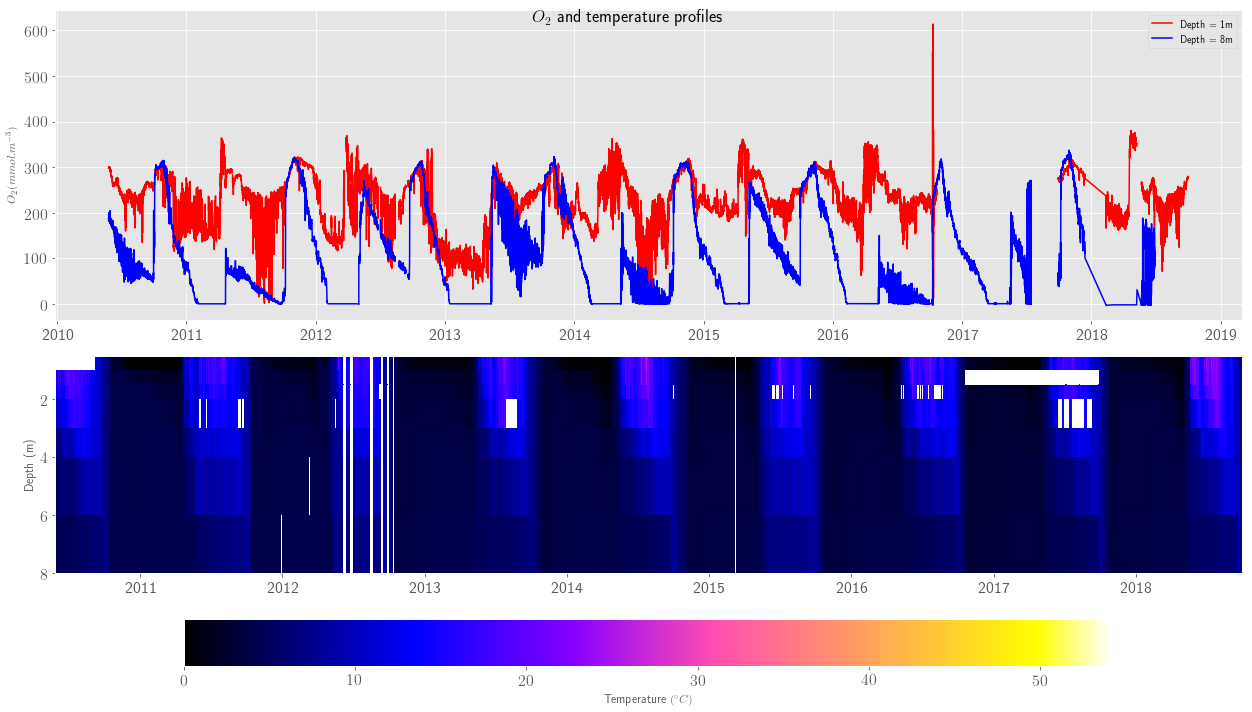

In [13]:
#Visualizationfig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (17.5, 10))
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (17.5, 10))

ma = np.ma.array(O2, mask=np.isnan(O2))
cmap = matplotlib.cm.gist_heat_r #jet #afmhot_r
cmap.set_bad('white',1.)
axes[0].plot(date_x,O2[1,:],'r-',label = "Depth = 1m")
axes[0].plot(date_x,O2[7,:],'b-',label = "Depth = 8m")
axes[0].legend()
axes[0].set_ylabel(r'$O_{2} (mmol.m^{-3})$')

t_y = np.r_[unik_depth_t, unik_depth_t[-1]]
t_x = date_x
t_x.append(date_x[-1] + datetime.timedelta(hours=1.5))
mat = np.ma.array(t, mask=np.isnan(t))
cmap = matplotlib.cm.gnuplot2 #afmhot_r
cmap.set_bad('white',1.)
im = axes[1].pcolormesh(t_x, t_y, mat, cmap = cmap)
axes[1].set_ylabel('Depth (m)')

axes[1].invert_yaxis()
plt.colorbar(im, orientation='horizontal', ax = axes[1], label =r'Temperature $\left(^{\circ}C\right)$')

fig.suptitle('$O_2$ and temperature profiles', size = 'xx-large')
fig.tight_layout()

In [14]:
#Saving the temperature and oxygen profiles in gotm format. Saving only depth and timesteps for which data exist.

to_string_date = lambda date,num_depths : datetime.datetime.strftime(date,'%Y-%m-%d %H:%M:%S') + \
                                      ' ' + str(num_depths) + ' ' + str(2) + '\n'
to_string_values = lambda depth,val : '-' + str(depth) + ' ' + str(val) + '\n'

to_string_values_acpy = lambda t,depth,val :  datetime.datetime.strftime(t,'%Y-%m-%d %H:%M:%S') + '\t' + \
                                              '-' + str(depth) + '\t' + str(val) + '\n'
#Saving data in GOTM/FABM format
def saveProfile(filename,data,depth,date) :
    fid = open(filename,'w')
    for col, t in zip(data.T,date) :
        num_val = sum(np.logical_not(np.isnan(col)))
        if num_val > 0 :
            fid.write(to_string_date(t,num_val))
            idx = np.where(np.logical_not(np.isnan(col)))
            for dummy,i in enumerate(idx) :
                for dummy, ii in enumerate(i) :
                    fid.write(to_string_values(depth[ii],col[ii]))
    fid.close
    
#Saving data in ACPY format
def saveProfileACPY(filename,data,depth,date) :
    fid = open(filename,'w')
    for col, t in zip(data.T,date) :
        num_val = sum(np.logical_not(np.isnan(col)))
        if num_val > 0 :
            idx = np.where(np.logical_not(np.isnan(col)))
            for dummy,i in enumerate(idx) :
                for dummy,ii in enumerate(i) :
                    fid.write(to_string_values_acpy(t,depth[ii],col[ii]))
    fid.close
            
saveProfile(result_dir + 'langtjern-lake-O2-concentration_mmol_m3.dat',O2,unik_depth_O2,date_x)
saveProfile(result_dir + 'langtjern-temp-lake.dat',t,unik_depth_t,date_x)

#Saving CDOM at outlet for ACPy
fid = open(result_dir + 'cdom.obs', 'w')
for i,j in outlet.iterrows() :
    fid.write (datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + '\t' + '-0.0' + '\t'  + str(j['CDOM']) + '\n')
fid.close
#Saving temperature for ACPy
saveProfileACPY(result_dir + 'temp.obs', t, unik_depth_t,date_x)

## Saving chemistry data provided by Leah

The data are located in *"\./Leah\_data/"*

In [15]:
basefolder = './Leah_data/'

#Loading the data in the format provided by Leah
input_outlet = pd.read_csv(basefolder + 'Ltj_MyLakeInput_Outlet.txt', sep = '\t', engine = 'python')
input_basin = pd.read_csv(basefolder + 'Ltj_MyLakeInput_S_basin.txt', sep = '\t', engine = 'python')

def keepFloat(df) : #This eliminates columns containing only zero
    df.set_index(pd.to_datetime(df.iloc[:,0:3]),inplace=True)
    df = df.loc[:,df.dtypes == 'float64']
    return df

input_outlet = keepFloat(input_outlet) 
input_basin = keepFloat(input_basin)

input_outlet.rename(columns = lambda x : re.sub('Outflow', '', x), inplace = 'True')
input_basin.rename(columns = lambda x : re.sub('Inflow', '', x), inplace = 'True')

#Saving data with the GOTM format
def saveVar(df,descriptor,isOut) :
    for name in df.columns :
        fid = open(result_dir + 'langtjern_' + descriptor + '_' + name + '.dat', 'w')
        print(result_dir, descriptor, name)
        for i,j in df[name].iteritems() :
            if isOut and name == 'Q' :
                to_save =  datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + \
                ' -' + str(j) + '\n'
            else :
                to_save =  datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + \
                ' ' + str(j) + '\n'
            fid.write(to_save)
        fid.close()
                    
#Saving the same period as the AquaMonitor data   
dtStart = datetime.datetime.strptime(fromDate + " 00:00:00", '%Y/%m/%d %H:%M:%S')
dtEnd = datetime.datetime.strptime(toDate + " 23:59:59", '%Y/%m/%d %H:%M:%S')         

saveVar(input_outlet.loc[(input_outlet.index>=dtStart) & (input_outlet.index<=dtEnd)],'outflow',True)
saveVar(input_basin.loc[(input_basin.index>=dtStart) & (input_basin.index<=dtEnd)],'inflow',False)

./results/ outflow Q
./results/ outflow DOC
./results/ inflow Q
./results/ inflow TP
./results/ inflow DOC
./results/ inflow NO3
./results/ inflow NH4


### Visualizing data


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe3b2f1ef0>],
      dtype=object)

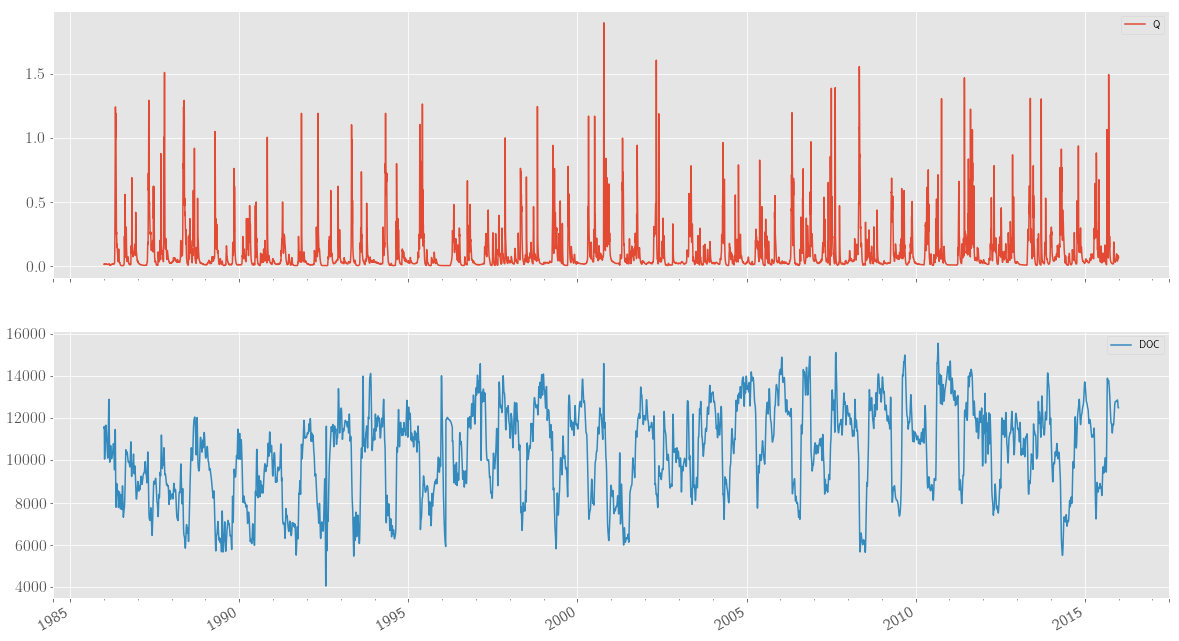

In [16]:
# fig = plot_df(input_outlet)
# fig.suptitle('Outlet variables', size = 'xx-large')
# fig.tight_layout()

input_outlet.plot(subplots=True, layout=(len(input_outlet.columns),1),figsize=(20,12))  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe1d7d2e10>],
      dtype=object)

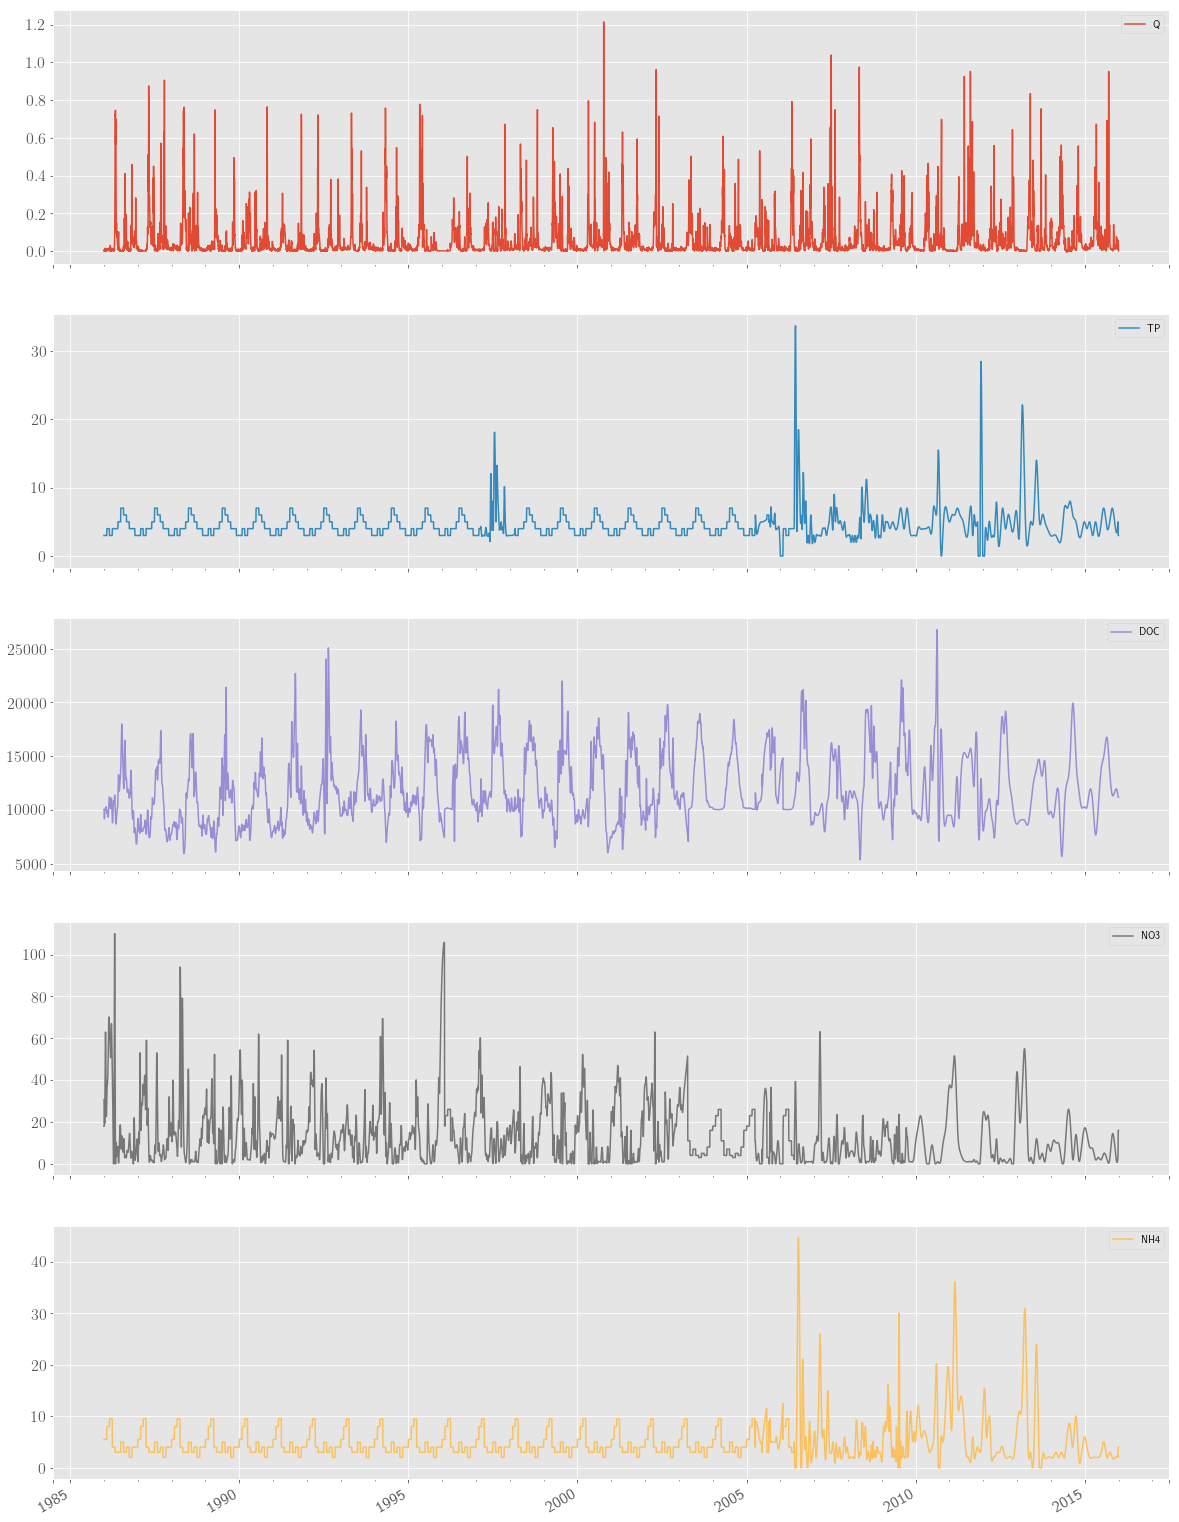

In [17]:
input_basin.plot(subplots=True, layout=(len(input_basin.columns),1),figsize=(20,30))  

## Finding correlation between TOC grab samples and CDOM high frequency measurements and transforming hf inlet CDOM to TOC

/home/jose-luis/Envs/prognos_get_data_py3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


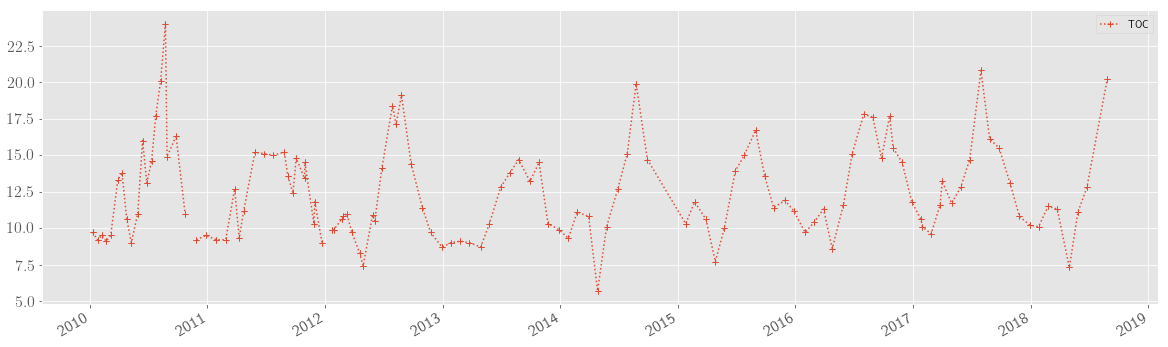

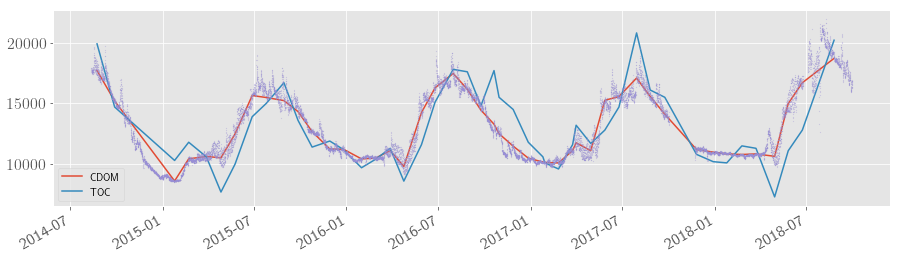

In [18]:
inlet = allData['inlet'].copy()
inlet.interpolate(inplace=True)

inlet.rename(columns={'Vannstand_m':'Discharge',u'CDOM_µg/L' : 'CDOM','Temperatur_C':'Temperature'},inplace=True)
inlet['Temperature'] = inlet['Temperature'].apply(lambda x : 0.0 if x < 0.0 else x)

TOC = allData['TOC']['TOC_mg/l'].copy()
TOC = TOC.to_frame()
TOC.rename(columns={'TOC_mg/l':'TOC'},inplace=True)
TOC.plot(figsize=(20,6),linestyle=':', marker='+')


TOC = TOC.resample('D').mean() * 1000
daily_cdom = inlet[['CDOM', 'Temperature']].resample('D').mean()
comparison_data = pd.concat([TOC, daily_cdom], axis=1, join_axes=[TOC.index]) 
comparison_data.dropna(inplace=True)


#Performing regression
X = comparison_data[['CDOM','Temperature']]
y = comparison_data['TOC'].to_frame()

# Note the difference in argument order
model = sm.RecursiveLS(y, X).fit()

#predictions = model.predict(X) # make the predictions by the model

comparison_data['CDOM'] = comparison_data['CDOM'] * model.params['CDOM'] + \
                          comparison_data['Temperature'] * model.params['Temperature']
comparison_data[['CDOM','TOC']].plot()

#CDOM correction
inlet['CDOM'] = model.params['CDOM'] * inlet['CDOM'] + model.params['Temperature'] * inlet['Temperature']
inlet['CDOM'].plot(linestyle='',marker='.',markersize=0.25)


#Saving to file
fcdom = open(result_dir + 'langtjern-inlet-cdom-mg-per-m3.dat','w')

for i,j in inlet.iterrows() :
    fcdom.write(datetime.datetime.strftime(i,'%Y-%m-%d %H:%M:%S') + ' ' + str(j.loc['CDOM']) + '\n')

fcdom.close()

In [19]:
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    TOC   No. Observations:                   47
Model:                    RecursiveLS   Log Likelihood                -407.320
Date:                Tue, 30 Oct 2018   AIC                            818.639
Time:                        09:23:23   BIC                            822.253
Sample:                             0   HQIC                           819.987
                                 - 47                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
CDOM          122.5264      4.708     26.027      0.000     113.300     131.753
Temperature   496.0497     68.260      7.267      0.000     362.262     629.837
===================================================================================
Ljung-Box (Q):                       85.14   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.00   Prob(JB):                         0.95
Heteroskedasticity (H):               2.24   Skew:                             0.04
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Parameters and covariance matrix estimates are RLS estimates conditional on the entire sample.
"""

[191.31200156 -25.27844703 142.96771961 140.64686279 133.28230164
 121.1761919  118.82013855 120.81627908 120.88427913 118.90420853
 118.58270555 116.96887438 119.93459141 120.40243657 119.45430873
 119.68930295 120.35207786 119.19091016 119.19298432 119.33195929
 118.89045635 118.42652813 118.34633378 120.70543965 123.01891556
 126.03316283 126.98527245 127.06444684 126.7598353  126.11873098
 126.26433001 127.15377962 127.2991071  127.23471169 127.27899709
 126.64370366 126.58272112 126.45649542 125.96930034 125.30557697
 124.75467054 125.02648762 125.14981196 123.43785773 122.94440754
 122.39317095 122.52643669]


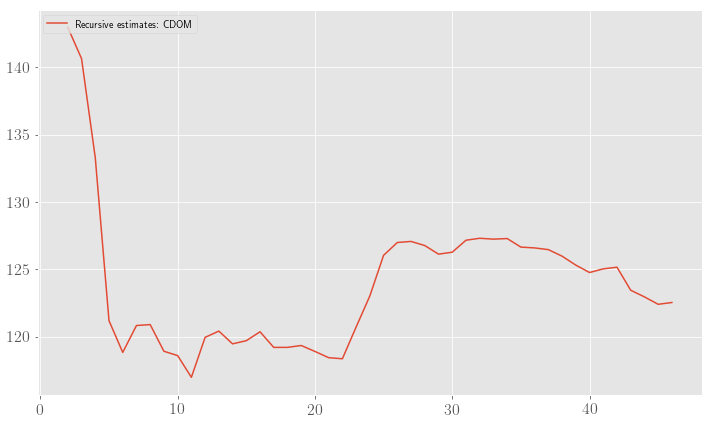

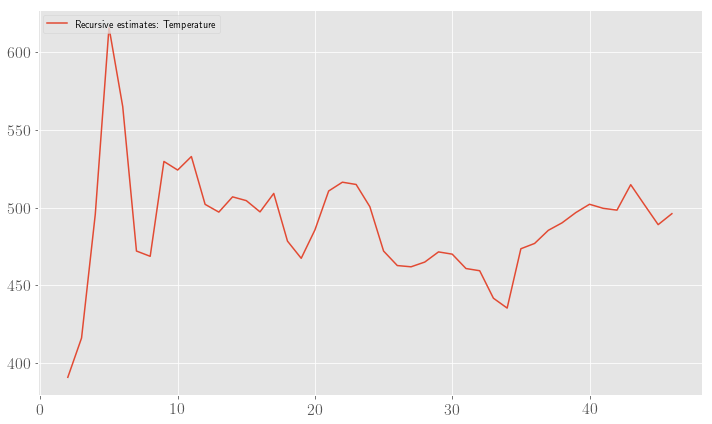

In [21]:
print(model.recursive_coefficients.filtered[0])
model.plot_recursive_coefficient(0, alpha=None, figsize=(10,6));
model.plot_recursive_coefficient(1, alpha=None, figsize=(10,6));